## Установка необходимых для работы библиотек
Необходимо выбрать `GPU` runtime type в настройках `runtime` google colab.
Обратите внимание, что установка может занять несколько минут (обычно 5 минут).

In [ ]:
# !pip install mesh_to_sdf pyrender trimesh
# !pip install torch torchvision
# !pip install git+https://github.com/facebookresearch/pytorch3d.git@v0.2.0

## Загрузка библиотек

In [2]:
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import torch

# untilitis 
from pytorch3d.utils import ico_sphere

# io utils
from pytorch3d.io import load_obj

# operations with data
from pytorch3d.ops import sample_points_from_meshes

# datastructures
from pytorch3d.structures import Meshes#, Textures
from pytorch3d.renderer.mesh import Textures

# mesh_to_sdf lib by marian42
from mesh_to_sdf import mesh_to_sdf, sample_sdf_near_surface

# render 
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras,
    DirectionalLights, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    HardPhongShader
)

# trimesh lib imports
import trimesh
from trimesh.voxel.creation import voxelize

In [3]:
# If you have got a CUDA device, you can use GPU mode
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.cuda.set_device(device)
else:
    device = torch.device('cpu')

# Полигональная модель

Загрузка полигональной модели `bunny.obj` с сайта [Stanford graphics](https://graphics.stanford.edu/~mdfisher/Data/Meshes/bunny.obj), в случае, если работаем в colab.

In [ ]:
# !mkdir data

In [4]:
!wget -nc -P ../data/ https://graphics.stanford.edu/~mdfisher/Data/Meshes/bunny.obj

File ‘../data/bunny.obj’ already there; not retrieving.



In [5]:
path_to_model = os.path.join("../data", "bunny.obj")

In [6]:
!head $path_to_model

### Создание полигональной икосферы sphere.obj с 4 уровнями subdivision

In [7]:
# Trimesh sphere .obj model
trimesh_sphere = trimesh.primitives.Sphere(subdivisions= 4)

# Sphere mesh in pytorch3d
sphere_mesh = ico_sphere(4, device)

verts_rgb = torch.ones_like(sphere_mesh.verts_list()[0])[None]

# Rainbow sphere in pytorch3d
# verts_rgb = torch.rand_like(sphere_mesh.verts_list()[0])[None]

sphere_mesh.textures = Textures(verts_rgb=verts_rgb.to(device))

### Создание полигональной модели кролика bunny.obj

In [8]:
# Trimesh bunny .obj model
bunny_trimesh = trimesh.load(path_to_model)

if isinstance(bunny_trimesh, trimesh.Scene):
    bunny_trimesh = bunny_trimesh.dump(concatenate=True)

bunny_trimesh.vertices -= bunny_trimesh.center_mass
scaling = 2 / bunny_trimesh.scale
bunny_trimesh.apply_scale(scaling=scaling)

# Rainbow bunny in trimesh
# for facet in bunny_trimesh.facets:
#   bunny_trimesh.visual.face_colors[facet] = trimesh.visual.random_color() 

# Bunny mesh in pytorch3d
verts, faces_idx, _ = load_obj(path_to_model)
faces = faces_idx.verts_idx

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)

# Rainbow bunny in pytorch3d
# verts_rgb = torch.rand_like(verts)[None]

textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the bunny.
bunny_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

# Блок визуализации

Визуализация моделей с помощью дифференциального рендера pytorch3d

In [11]:
# Initialize an OpenGL perspective camera.
cameras = OpenGLPerspectiveCameras(device=device)

# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=1024, 
    blur_radius=0, 
    faces_per_pixel=1, 
)

# We can add a directional light in the scene. 
ambient_color = torch.FloatTensor([[0.0, 0.0, 0.0]]).to(device)
diffuse_color = torch.FloatTensor([[1.0, 1.0, 1.0]]).to(device)
specular_color = torch.FloatTensor([[0.1, 0.1, 0.1]]).to(device)
direction = torch.FloatTensor([[1, 1, 1]]).to(device)
lights = DirectionalLights(ambient_color=ambient_color,
                           diffuse_color=diffuse_color,
                           specular_color=specular_color,
                           direction=direction,
                           device=device)

phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
        )
)

In [12]:
# Select the viewpoint using spherical angles  
distance = 2.0   # distance from camera to the object`
elevation = 40.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device,at=((-0.02,0.1,0.0),))

# Render the bunny providing the values of R and T. 
image_bunny = phong_renderer(meshes_world=bunny_mesh, R=R, T=T)

In [13]:
# Select the viewpoint using spherical angles  
distance = 3.0   # distance from camera to the object`
elevation = 40.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device,at=((-0.02,0.1,0.0),))

# Render the sphere providing the values of R and T. 
image_sphere = phong_renderer(meshes_world=sphere_mesh, R=R, T=T)

# Полигональные модели

### Визуализация в pytorch3d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


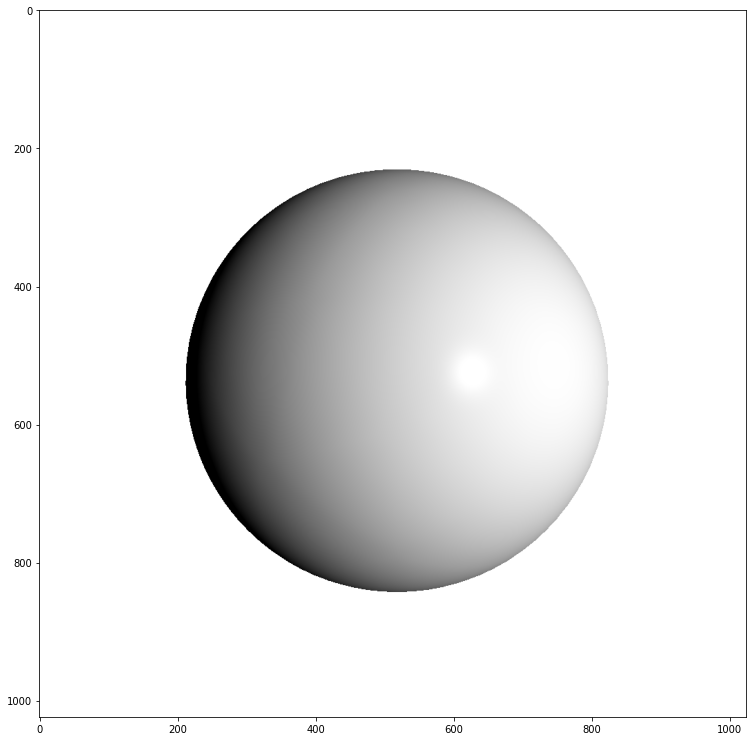

In [14]:
image_sphere = image_sphere.cpu().numpy()

plt.figure(figsize=(13, 13))
plt.imshow(image_sphere.squeeze())
plt.grid(False)

In [26]:
bunny_trimesh

<trimesh.Trimesh(vertices.shape=(2503, 3), faces.shape=(4968, 3))>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


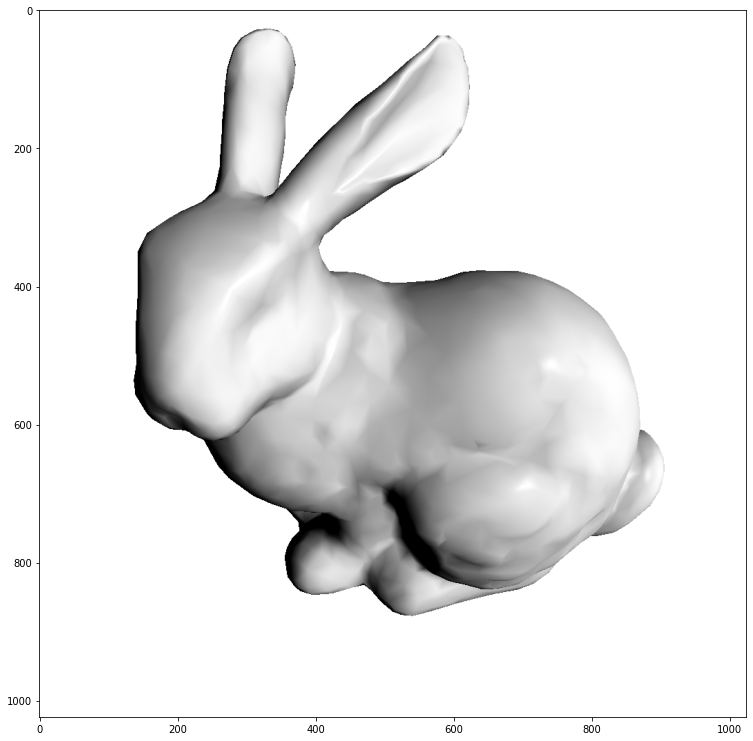

In [15]:
image_bunny = image_bunny.cpu().numpy()

plt.figure(figsize=(13, 13))
plt.imshow(image_bunny.squeeze())
plt.grid(False)

### Интерактивная визуализация в trimesh

In [16]:
trimesh_sphere.show()

In [17]:
bunny_trimesh.show()

 ### Для полигональных моделей как для пространственных графов можно вычислить ряд геометрических характеристик.

In [27]:
print(
    "Эйлерова характеристика пространственного графа модели bunny Xi = V - E + F =",
    bunny_trimesh.euler_number
)

print(
    "Эйлерова характеристика пространственного графа модели sphere Xi = V - E + F =",
    trimesh_sphere.euler_number
)

Эйлерова характеристика пространственного графа модели bunny Xi = V - E + F = -2
Эйлерова характеристика пространственного графа модели sphere Xi = V - E + F = 2


In [28]:
print("Is bunny mesh watertight:", bunny_trimesh.is_watertight)
print("Is sphere mesh watertight:", trimesh_sphere.is_watertight)

Is bunny mesh watertight: False
Is sphere mesh watertight: True


In [29]:
print("Объем модели bunny.obj:", bunny_trimesh.volume)
print("Объем модели sphere.obj:", trimesh_sphere.volume)

Объем модели bunny.obj: 0.3876657353353089
Объем модели sphere.obj: 4.1887902047863905


In [30]:
# Объем единичной сферы 4/3 * Pi
(4/3)*np.pi

4.1887902047863905

# Воксельное представление

In [31]:
low_idx_bunny = bunny_trimesh.scale / 15
high_idx_bunny = bunny_trimesh.scale / 39
low_idx_sphere = trimesh_sphere.scale / 15
high_idx_sphere = trimesh_sphere.scale / 30

In [32]:
vox_high_bunny = voxelize(bunny_trimesh,pitch=high_idx_bunny)
vox_high_sphere = voxelize(trimesh_sphere,pitch=high_idx_sphere)

In [33]:
print("Срез воксельной сетки:\n",np.array(vox_high_sphere.matrix, dtype=np.uint8)[1])

Срез воксельной сетки:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [34]:
print("Размер воксельной сетки с высоким разрешением:", vox_high_sphere.shape)

Размер воксельной сетки с высоким разрешением: (19, 19, 19)


In [35]:
vox_high_sphere.show()

In [36]:
vox_high_bunny.show()

In [37]:
vox_low_bunny = voxelize(bunny_trimesh,pitch=low_idx_bunny)
vox_low_sphere = voxelize(trimesh_sphere,pitch=low_idx_sphere)

In [38]:
print("Размер воксельной сетки с низким разрешением:", vox_low_sphere.shape)

Размер воксельной сетки с низким разрешением: (9, 9, 9)


In [39]:
vox_low_sphere.show()

In [40]:
vox_low_bunny.show()

# Облако точек

Визуализация облака точек, полученного из полигональной модели методом семплирования точек на гранях обоими методами.

### Преобразование полигональной модели к облаку точек с нормалями

Один из основных способов создания модели облака точек из существующей полигональной модели - равномерное семплирование дополнительных вершин на гранях полигональной модели. 

Эту задачу можно решать как встроеными методами библиотек - `sample_points_from_meshes` в *pytorch3d*, или же можно сакмому написать алгоритм семплирования и использовать его.

In [9]:
# Mesh to pointcloud with normals in pytorch3d
num_points_to_sample = 25000

bunny_vert, bunny_norm = sample_points_from_meshes(
    bunny_mesh,
    num_points_to_sample ,
    return_normals=True
)

sphere_vert, sphere_norm = sample_points_from_meshes(
    sphere_mesh,
    num_points_to_sample,
    return_normals=True
)

In [10]:
def plot_pointcloud(points, elev=70, azim=-70, title=""):
    # Sample points uniformly from the surface of the mesh.
    fig = plt.figure(figsize=(10, 10))
    ax = Axes3D(fig)
    x, y, z = points
    ax.scatter3D(x, z, -y,marker='.')  
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(elev, azim)
    plt.show()

Облако точек модели bunny.obj, полученное семплированием с помощью алгоритма из pytorch3d.

<ipython-input-10-49b2c1f08421>:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


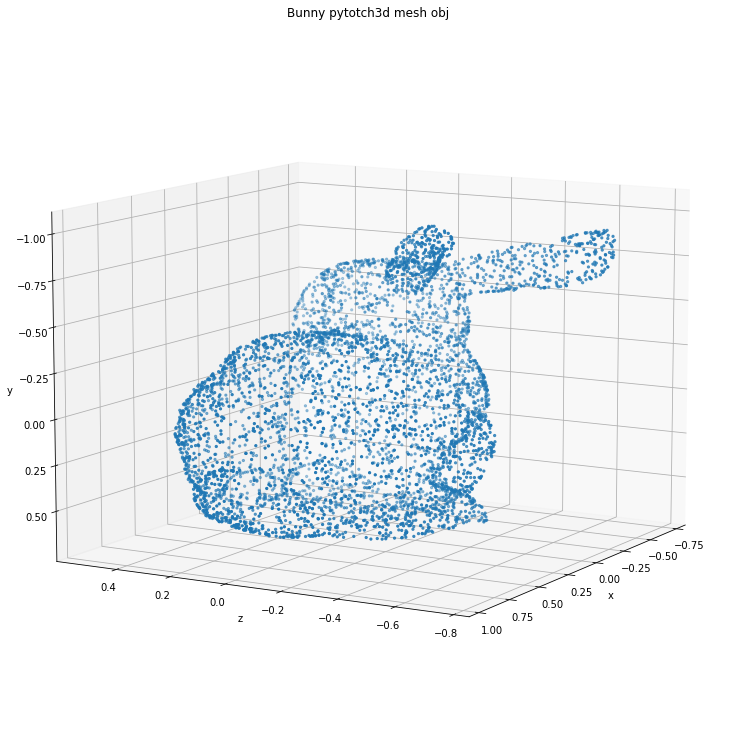

In [41]:
points = sample_points_from_meshes(bunny_mesh, 5000)
points = points.clone().detach().cpu().squeeze().unbind(1)
plot_pointcloud(points, elev=190, azim=150, title='Bunny pytotch3d mesh obj')

Облако точек модели sphere.obj, полученное семплированием с помощью алгоритма из pytorch3d.

<ipython-input-10-49b2c1f08421>:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


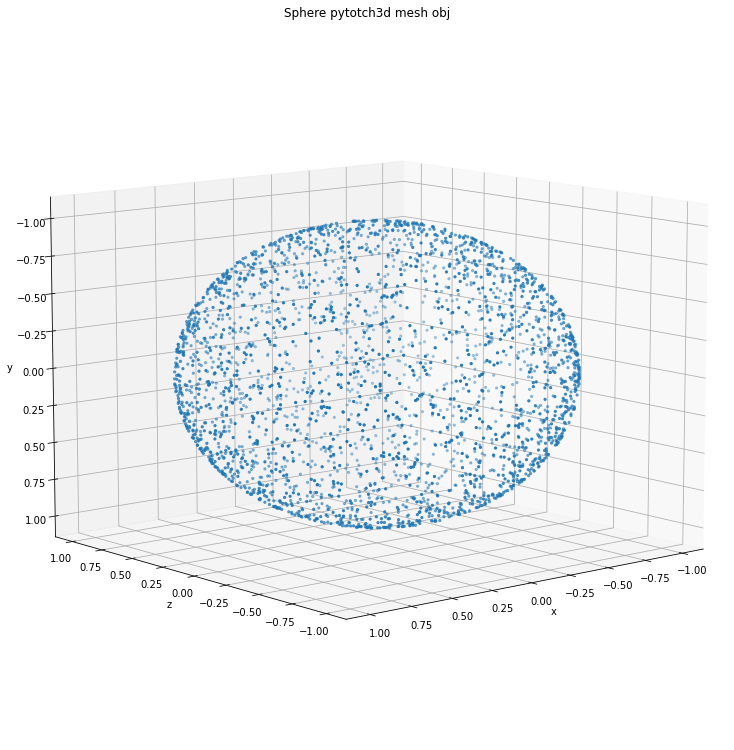

In [42]:
points = sample_points_from_meshes(sphere_mesh, 3000)
points = points.clone().detach().cpu().squeeze().unbind(1)
plot_pointcloud(points, elev=190, azim=130, title='Sphere pytotch3d mesh obj')

# Вычисление SDF функции

Вычисление SDF функции для модели bunny.obj в двух точках: одной внутренней (центр масс), одной внешней.

In [45]:
center_mass = bunny_trimesh.center_mass
query_points = np.array([[center_mass],[[3,3,3]]])

In [47]:
for point in query_points:
    print("SDF{0} = {1}".format(point[0],mesh_to_sdf(bunny_trimesh,point)[0]))

SDF[-0.00036814  0.01044934 -0.00012521] = -0.26789188385009766
SDF[3. 3. 3.] = 4.746806621551514


Вычисление SDF функции для модели sphere.obj в двух точках: одной внутренней (центр масс), одной внешней.

In [48]:
center_mass = trimesh_sphere.center_mass
query_points = np.array([[center_mass],[[3,3,3]]])

In [49]:
for point in query_points:
    print("SDF{0} = {1}".format(point[0],mesh_to_sdf(trimesh_sphere,point)[0]))

SDF[ 0.0000000e+00  0.0000000e+00 -8.8540061e-18] = -0.998867392539978
SDF[3. 3. 3.] = 4.195399761199951


Визуализируем 

In [50]:
points, sdf = sample_sdf_near_surface(trimesh_sphere, number_of_points=5000)

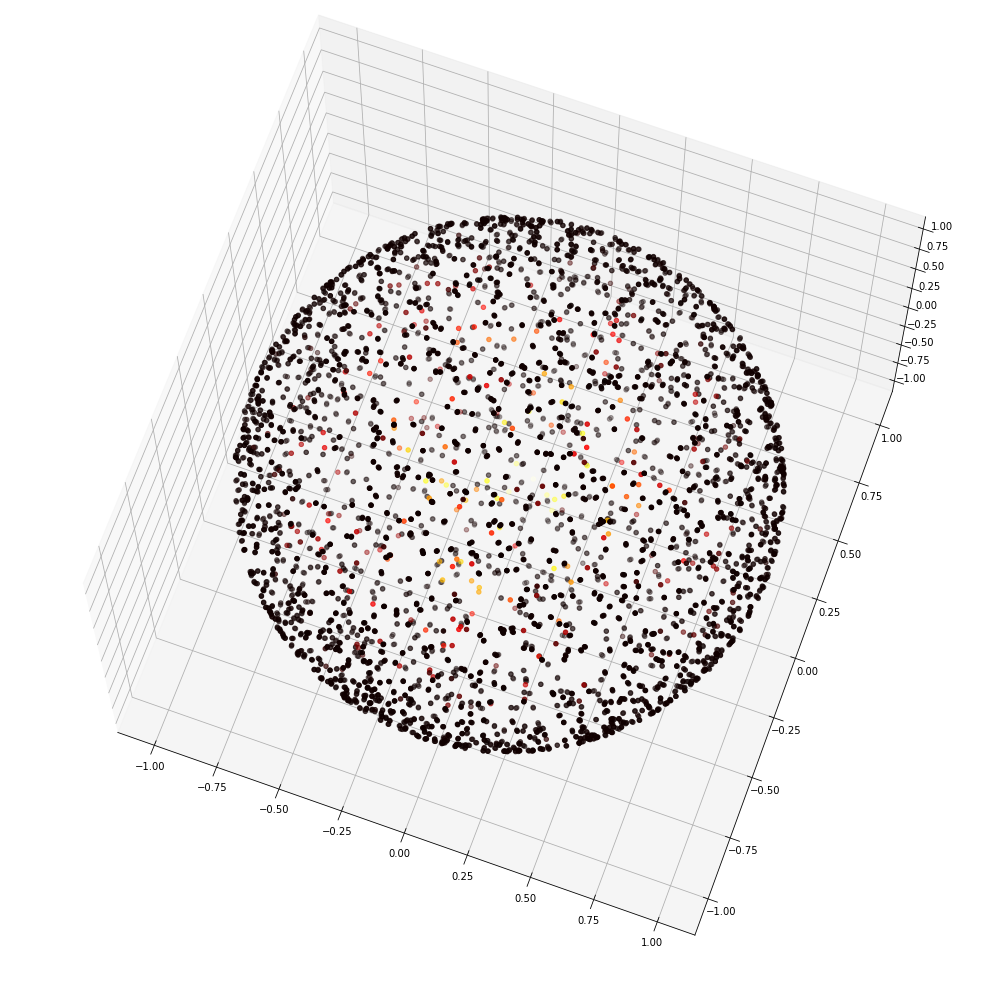

In [51]:
fig = plt.figure(figsize=(20, 18))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(elev=70, azim=-70)
ax.scatter(points[:, 0], points[:, 1], zs=-points[:, 2], c=sdf, cmap="hot_r")

In [52]:
points, sdf = sample_sdf_near_surface(bunny_trimesh, number_of_points=5000)

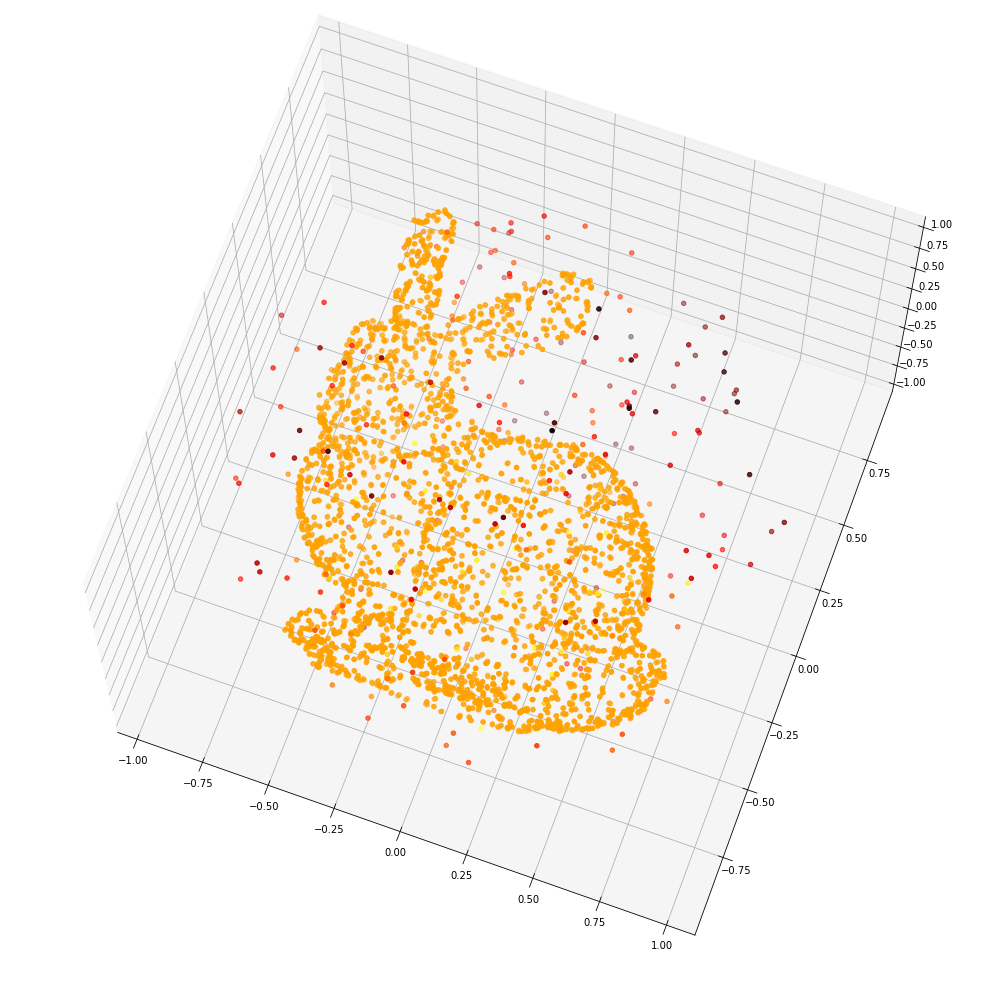

In [53]:
fig = plt.figure(figsize=(20, 18))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(elev=70, azim=-70)
ax.scatter(points[:, 0], points[:, 1], zs=-points[:, 2], c=sdf, cmap="hot_r")